# Quickstart

In this tutorial, we will go over how to instantiate a `StarryProcess` object, how to sample from it, and how to use it to compute light curve likelihoods and do basic inference.

In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Disable annoying font warnings
matplotlib.font_manager._log.setLevel(50)

# Disable theano deprecation warnings
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="theano")

# Style
plt.style.use("default")
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["font.size"] = 14
plt.rcParams["text.usetex"] = False
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Liberation Sans"]
plt.rcParams["font.cursive"] = ["Liberation Sans"]
plt.rcParams["mathtext.fontset"] = "cm"
try:
    plt.rcParams["mathtext.fallback"] = "cm"
except KeyError:
    plt.rcParams["mathtext.fallback_to_cm"] = True

# Short arrays when printing
np.set_printoptions(threshold=0)

## Setup

Let us begin by importing the GP class we'll use, ``StarryProcess``, as well as some standard stuff:

In [4]:
from starry_process import StarryProcess
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

Let us instantiate a `StarryProcess` object with default values for everything:

In [5]:
sp = StarryProcess()

The hyperparameters of the GP are as follows:

In [6]:
from IPython.display import display, Markdown
from starry_process.defaults import defaults

defaults["mu"] = defaults.get("mu", None)
defaults["sigma"] = defaults.get("sigma", None)
display(
    Markdown(
        """
| attribute | description | default value |
| - | :- | :-:
| `r` | mean radius in degrees | `{r}` |
| `dr` | radius distribution half-width in degrees | `{dr}`|
| `a` | latitude distribution shape parameter | `{a}` |
| `b` | latitude distribution shape parameter | `{b}` |
| `mu` | latitude distribution mode in degrees | `{mu}` |
| `sigma` | latitude distribution standard deviation in degrees | `{sigma}` |
| `c` | fractional spot contrast | `{c}` |
| `n` | number of spots | `{n}` |
""".format(
            **defaults
        )
    )
)


| attribute | description | default value |
| - | :- | :-:
| `r` | mean radius in degrees | `20.0` |
| `dr` | radius distribution half-width in degrees | `None`|
| `a` | latitude distribution shape parameter | `0.4` |
| `b` | latitude distribution shape parameter | `0.27` |
| `mu` | latitude distribution mode in degrees | `None` |
| `sigma` | latitude distribution standard deviation in degrees | `None` |
| `c` | fractional spot contrast | `0.1` |
| `n` | number of spots | `10.0` |


Two notes about these parameters.
First, by default, the radius distribution is a delta function centered at `r`; setting `dr`
to a numerical value changes this to a uniform distribution between `r - dr` and `r + dr`.
Second, by default, the latitude distribution is specified via the dimensionless shape
parameters `a` and `b`. These have a one-to-one correspondence with the mode `mu`
and standard deviation `sigma` of the distribution, which users can choose to specify instead.

Let's print the value of one of these hyperparameters as an example:

In [7]:
sp.r

Elemwise{mul,no_inplace}.0

Not quite what we expected! That's because `starry_process` is built on `theano`, a just-in-time compiled graph-based language. Unless we explicitly evaluate variables, they are just nodes in a graph: instructions on *how* to perform a given operation. This may be a bit of a nuisance at times, but it's what makes `starry_process` so fast while enabling the automatic differentiation needed for integration with inference suites like `pymc3`.

Evaluating a `theano` tensor variable is super easy:

In [8]:
sp.r.eval()

array(20.)

That's more like it! We can now check that all of the parameters are in fact set to their default values:

In [9]:
for param in ["r", "dr", "a", "b", "mu", "sigma", "c", "n"]:
    print("{} = {}".format(param, getattr(sp, param).eval()))

r = 20.0
dr = 0.0
a = 0.4
b = 0.27
mu = 30.227847730416745


sigma = 4.942895774884616
c = 0.1
n = 10.0


Note that the `mu` and `sigma` parameters of the latitude distribution were automatically computed (since they are one-to-one functions of `a` and `b`). The default hyperparameters of the GP therefore correspond to 10 spots of radii $20^\circ$ at $30^\circ \pm 5^\circ$ latitude with 10% contrast.

## Sampling

### Sampling in spherical harmonics

Now that we've instantiated the GP, the simplest thing we can do is sample from it. There are two quantities we can sample: the surface map of the star and its corresponding light curve. The former is done by calling

In [10]:
y = sp.sample_ylm().eval()

where `ylm` refers to the fact that the surface map is expressed in the spherical harmonic $Y_{l,m}$ basis, and we call `eval()` because, as before, we are dealing with `theano` tensors. The quantity `y` is the vector of spherical harmonic coefficients describing the surface:

In [11]:
y

array([[-0.09482117, -0.00381494,  0.00946731, ..., -0.00161086,
        -0.0012145 ,  0.00261073]])

Its shape is `(number of samples, number of coefficients)`:

In [12]:
y.shape

(1, 256)

(To get more samples, we could have used the `nsamples` kwarg to `sample_ylm()`.)

The vector has $(l_\mathrm{max} + 1)^2 = 256$ elements, since it is an expansion up to spherical harmonic degree $l_\mathrm{max} = 15$. The easiest way to visualize the corresponding surface map is via the `visualize` method:

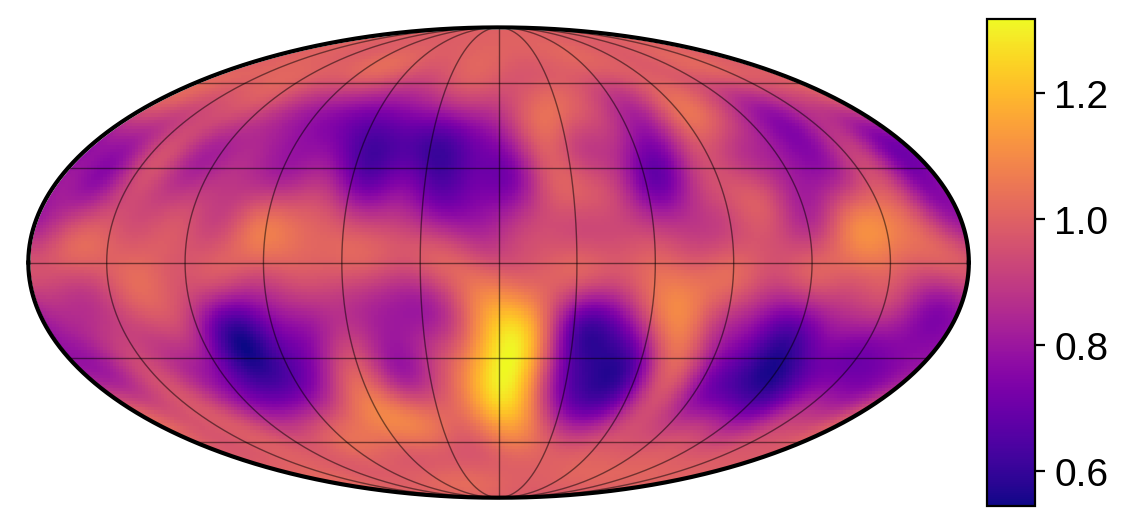

In [13]:
sp.visualize(y, colorbar=True)

We're seeing the surface in a Mollweide projection in normalized units (i.e., the unspotted photosphere has an intensity of unity). The features cluster at about $\pm30^\circ$ latitude and have roughly the expected size. However, there are some bright features, some spots are darker than we'd expect, and there aren't exactly 10 spots $-$ this is all expected, since a stellar surface is not *really* a Gaussian process. What we're doing is just an approximation that works OK for sampling (but really well for inference).

We can also compute the light curve corresponding to this surface map. Let's define a time array spanning four rotations and evaluate the corresponding flux.

In [14]:
t = np.linspace(0, 4, 250)
flux = sp.flux(y, t).eval()
flux

array([[ 0.00063662, -0.00043836, -0.00144197, ...,  0.00337915,
         0.00190472,  0.00063662]])

Since we didn't explicitly provide them in the call to `flux()`, the stellar inclination `i`, rotation period `p`, and limb darkening coefficient vector `u` all assume their default values:

In [15]:
defaults["u"] = defaults["u"][: defaults["udeg"]]
display(
    Markdown(
        """
| attribute | description | default value |
| - | :- | :-:
| `i` | stellar inclination in degrees | `{i}` |
| `p` | stellar rotation period in days | `{p}`|
| `u` | limb darkening coefficient vector | `{u}` |
""".format(
            **defaults
        )
    )
)


| attribute | description | default value |
| - | :- | :-:
| `i` | stellar inclination in degrees | `60.0` |
| `p` | stellar rotation period in days | `1.0`|
| `u` | limb darkening coefficient vector | `[0. 0.]` |


Note also the shape of the flux vector, which is `(number of samples, number of time points)`:

In [16]:
flux.shape

(1, 250)

Here's the flux as a function of time:

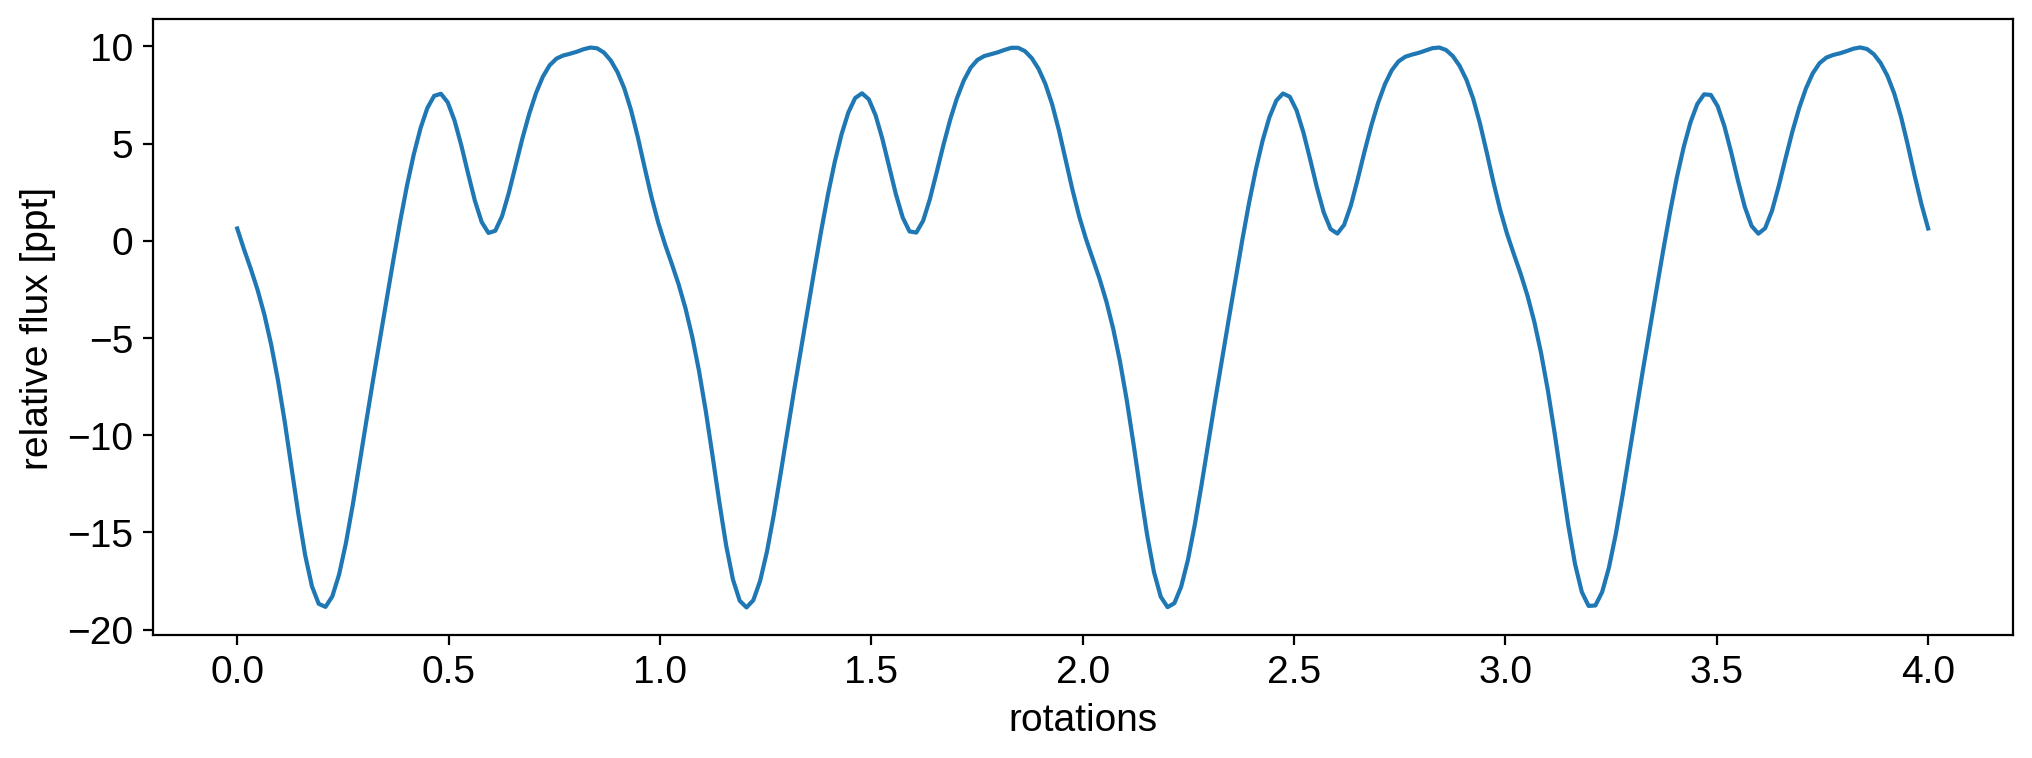

In [17]:
plt.plot(t, 1e3 * flux[0])
plt.xlabel("rotations")
plt.ylabel("relative flux [ppt]")
plt.show()

### Sampling in flux

If what we ultimately want are light curve samples, we can skip the map generation step entirely and simply call

In [18]:
flux = sp.sample(t, nsamples=50, eps=1e-8).eval()
flux

array([[ 0.07143628,  0.06784619,  0.06307815, ...,  0.07649214,
         0.07427469,  0.07157924],
       [ 0.01256231,  0.01597659,  0.01969458, ...,  0.00660884,
         0.00965758,  0.0124819 ],
       [ 0.05377913,  0.05593556,  0.05656534, ...,  0.04681426,
         0.05091243,  0.05383528],
       ...,
       [-0.04979364, -0.05830166, -0.06653111, ..., -0.03266614,
        -0.04126374, -0.04978642],
       [ 0.00552055,  0.00402212,  0.00246439, ...,  0.0092558 ,
         0.00750752,  0.00553287],
       [ 0.02269777,  0.02969439,  0.03587467, ...,  0.00765146,
         0.01542264,  0.02271021]])

In [19]:
flux.shape

(50, 250)

where this time we asked for 50 samples evaluated at times `t` (defined above). The `eps` parameter is the extra variance we add to the covariance matrix for stability; sometimes it may be necessary to tweak this depending on the application.

Let's plot our samples:

In [20]:
y.shape

(1, 256)

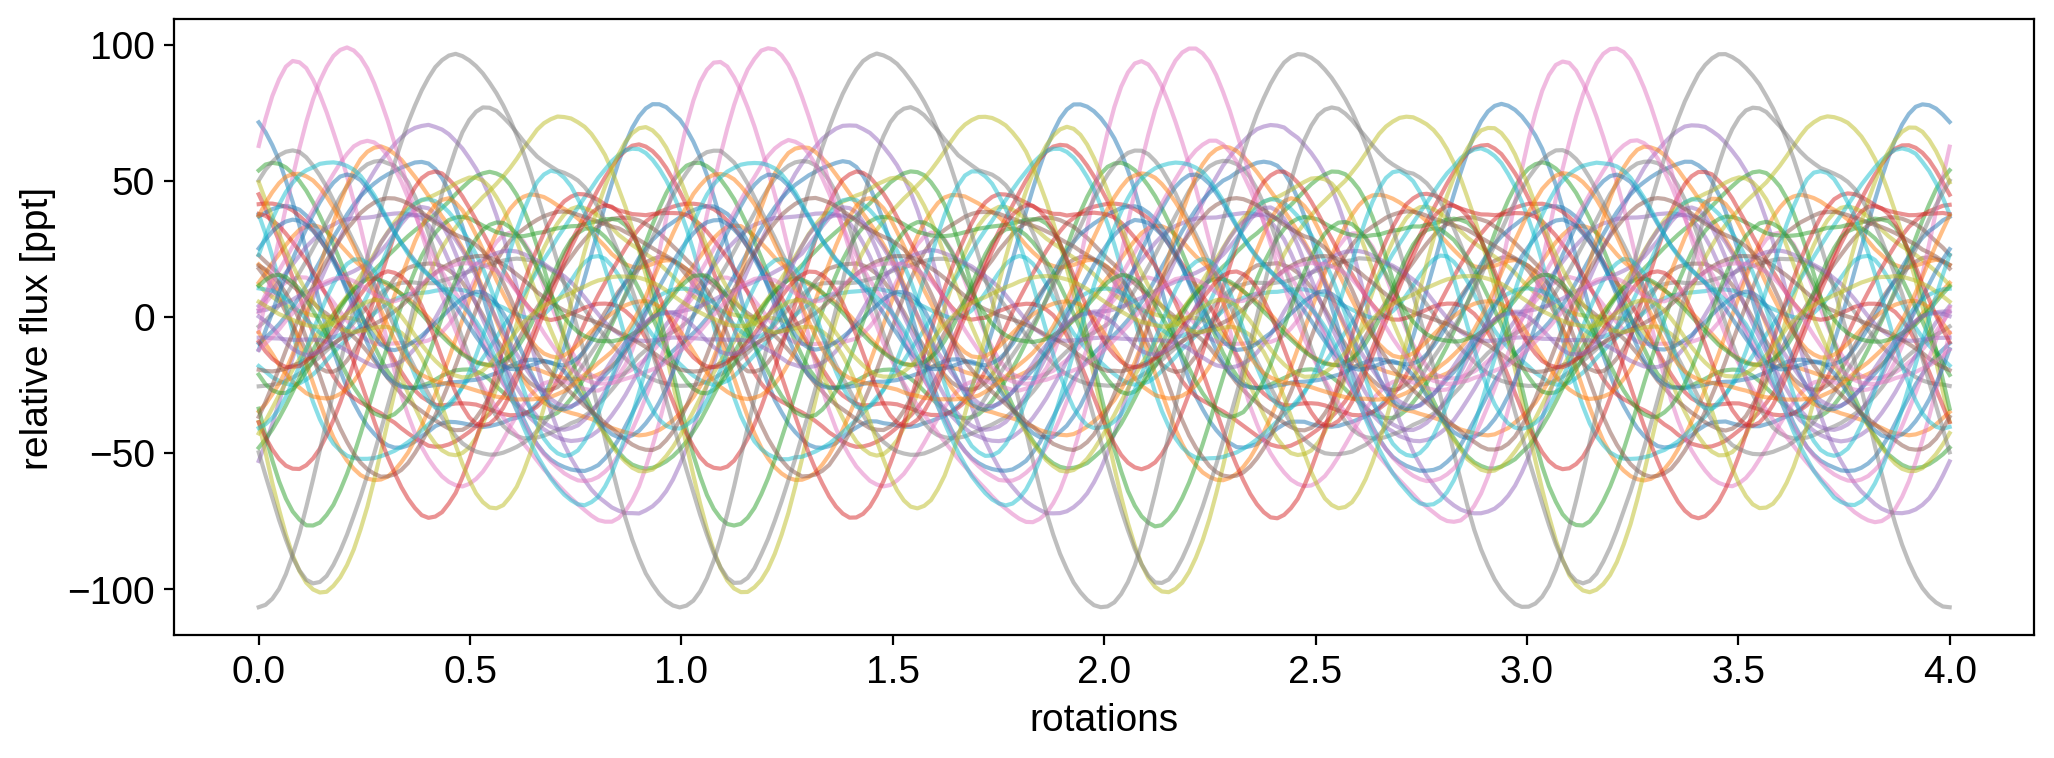

In [21]:
for k in range(50):
    plt.plot(t, 1e3 * flux[k], alpha=0.5)
plt.xlabel("rotations")
plt.ylabel("relative flux [ppt]")
plt.show()

By default, `StarryProcess` marginalizes over inclination. That means each of these samples corresponds to a different random inclination drawn from an isotropic distribution between $0^\circ$ and $90^\circ$ (the distribution is actually just $p(I) = \sin I$). If we wanted to condition on a specific inclination, we would pass `marginalize_over_inclination=False` when instantiating the `StarryProcess`, and explicitly pass a value for `i` in the call to `sample()`.

## Doing inference

Chances are the real reason you're using a GP is to do inference with it. That is, we're interested in the *likelihood function* associated with the Gaussian process, which we can use to compute posterior probabilities of our model parameters conditioned on some data. The cool thing about a ``StarryProcess`` is that the likelihood is explicitly a function of the properties of the spots (the parameters we pass when instantiating the class). This is a *marginal* likelihood, since it's already implicitly integrated over all the possible ways spots with certain properties (e.g., a certain radius and a certain latitude distribution) can be arranged on the surface of a star. So we don't need any parameters specifying the *particular* properties of *individual* spots: just the parameters of the *distribution* of spots as a whole. When we do inference, those are the parameters we are trying to constrain.

Computing likelihoods from a `StarryProcess` is done via the `log_likelihood()` method. To see how this works, let's take the light curves we generated in the previous section and add a bit of noise to them to mimic a real observation. Here's the first one:

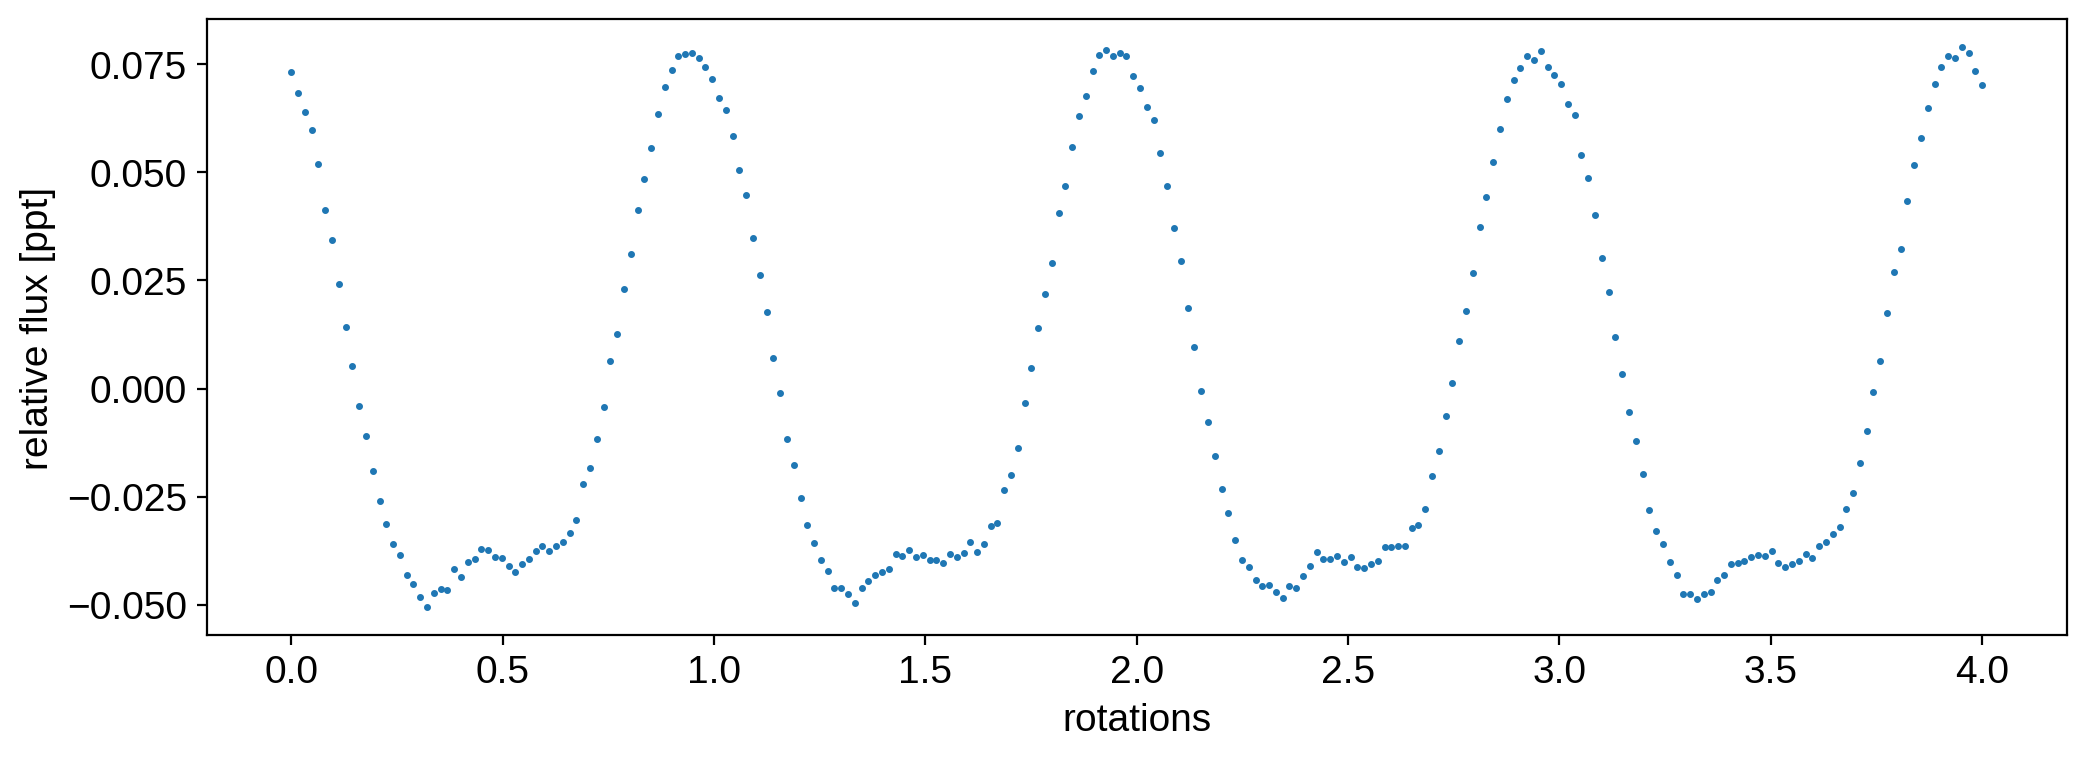

In [22]:
ferr = 1e-3
np.random.seed(0)
f = flux + ferr * np.random.randn(50, len(t))
plt.plot(t, f[0], "C0.", ms=3)
plt.xlabel("rotations")
plt.ylabel("relative flux [ppt]")
plt.show()

The light curve is `f` and the photometric uncertainty (i.e., the standard deviation of the data) is `sigma`. We can compute the likelihood of this dataset conditioned on the current parameters of the `StarryProcess` (which happen to be the ones that generated it!) by evaluating

In [23]:
sp.log_likelihood(t, f[0], ferr ** 2).eval()

array(1323.83365552)

That number on its own doesn't mean that much; likelihoods are really only significant in a relative sense (or if we plug them into a sampler to compute actual posterior probabilities). Therefore, let's explore how the likelihood varies as we vary the parameters of our Gaussian process (remembering that the current, default parameters are the "true" ones).

If you executed that lest cell yourself, you may have noticed it took many seconds to evaluate. That's because evaluating tensor variables in this manner is extremely slow, as none of the optimizations are enabled. To take advantage of those, we need to explicitly **compile** the functions we're interested in. In order to do that, let's take a short detour into the workings of `theano`.

## Compiling `theano` functions

Even though we called the `eval()` method a few times above, it's usually a **bad idea** to do that, mostly because it's so slow! The real power of algorithms implemented in `theano` comes out when you compile them. To do that, let's import some stuff:

In [24]:
import theano
import theano.tensor as tt

Now, as a concrete example, let's compile the log likelihood function from the previous section. In order to do that, we need to think for a second about what the **inputs** and **outputs** of our function will be. The output is easy: we simply want the numerical value of the log likelihood. As for the inputs, a lot of things go into the computation of the likelihood: namely, the three arguments to the `log_likelihood()` call (the time vector `t`, the flux vector `f`, and the flux uncertainty `sigma`), *as well as* all of the parameters of the GP. We didn't explicitly pass any when we instantiated the GP (we just kept them at their default values), but the likelihood certainly depends on them as well.

We want the inputs to our function to be anything we'll want to be able to change when we call it, so that kind of depends on the use case. For concreteness, let's compile a function whose explicit inputs are two single quantities: the flux vector `f` and the spot radius `r`. The GP depends on a whole bunch of other stuff, but those will be constants $-$ that is, things like the time vector `t` or the spot contrast `c` will be baked into the function when we compile it.

In order to allow the flux and the radius to vary, we won't give it them numerical values when compiling the function. Instead, we will make them tensor variables: placeholders for numerical values that can be operated on within the computational graph:

In [25]:
f_tensor = tt.dvector()
r_tensor = tt.dscalar()

Note that `theano` allows tensors with different numeric types (`bool`, `int`, `float`, ...) and of different dimensionality (`scalar`, `vector`, `matrix`, ...). Here we're simply telling `theano` that the flux is a vector quantity with double precision (hence the "d" in "dvector"), and the radius is a double precision scalar quantity. Note also that I added the suffix `_tensor` to both variables so we don't get name conflicts (since we're already using the variable `f` to denote the actual *numerical* value of the flux).

Now, let's instantiate our `StarryProcess` and compute the likelihood (without calling the `eval()` method):

In [26]:
sp = StarryProcess(r=r_tensor)
log_likelihood_tensor = sp.log_likelihood(t, f_tensor, ferr ** 2)

The quantity `log_likelihood_tensor` is a tensor variable representing the log likelihood of the process as a function of a bunch of stuff, including the tensor radius and tensor flux defined above. Note that we passed in quantities like `t` and `ferr` as actual numerical values, which means they will be baked into the function when we actually compile it.

To compile a `theano` function, we do

```python
func = theano.function(inputs, output)
```

where `func` is a callable that accepts and returns numeric values corresponding to the list of `inputs` and to `output`.

In [27]:
log_likelihood = theano.function([f_tensor, r_tensor], log_likelihood_tensor)

The quantity `log_likelihood` is now a compiled function that takes in a vector and a scalar and outputs a scalar. Let's call it on the synthetic light curve from the previous section, using the default value of the radius:

In [28]:
log_likelihood(f[0], 20.0)

array(1323.83365552)

Note that we got the same value as before, but there's one big difference: the function ran almost instantly. Now that we have an efficient likelihood function, let's get back to our section on inference!

## Doing inference (continued)

The whole point of inference is that we don't typically know the parameters of our model. So let's compute the log likelihood over an array of values of the spot radius (while keeping everything else fixed at the true value).

In [29]:
r = np.linspace(10, 45, 100)
ll = np.zeros_like(r)
for k in tqdm(range(len(r))):
    ll[k] = log_likelihood(f[0], r[k])

  0%|          | 0/100 [00:00<?, ?it/s]

Let's plot the actual likelihood as a function of radius. Note that it's usually necessary to subtract the maximum value of the log likelihood before exponentiating to avoid overflow (or underflow). Remember that the normalization of the likelihood isn't meaningful, so we can add and subtract constants in log space to our heart's content without changing the *relative* probabilities.

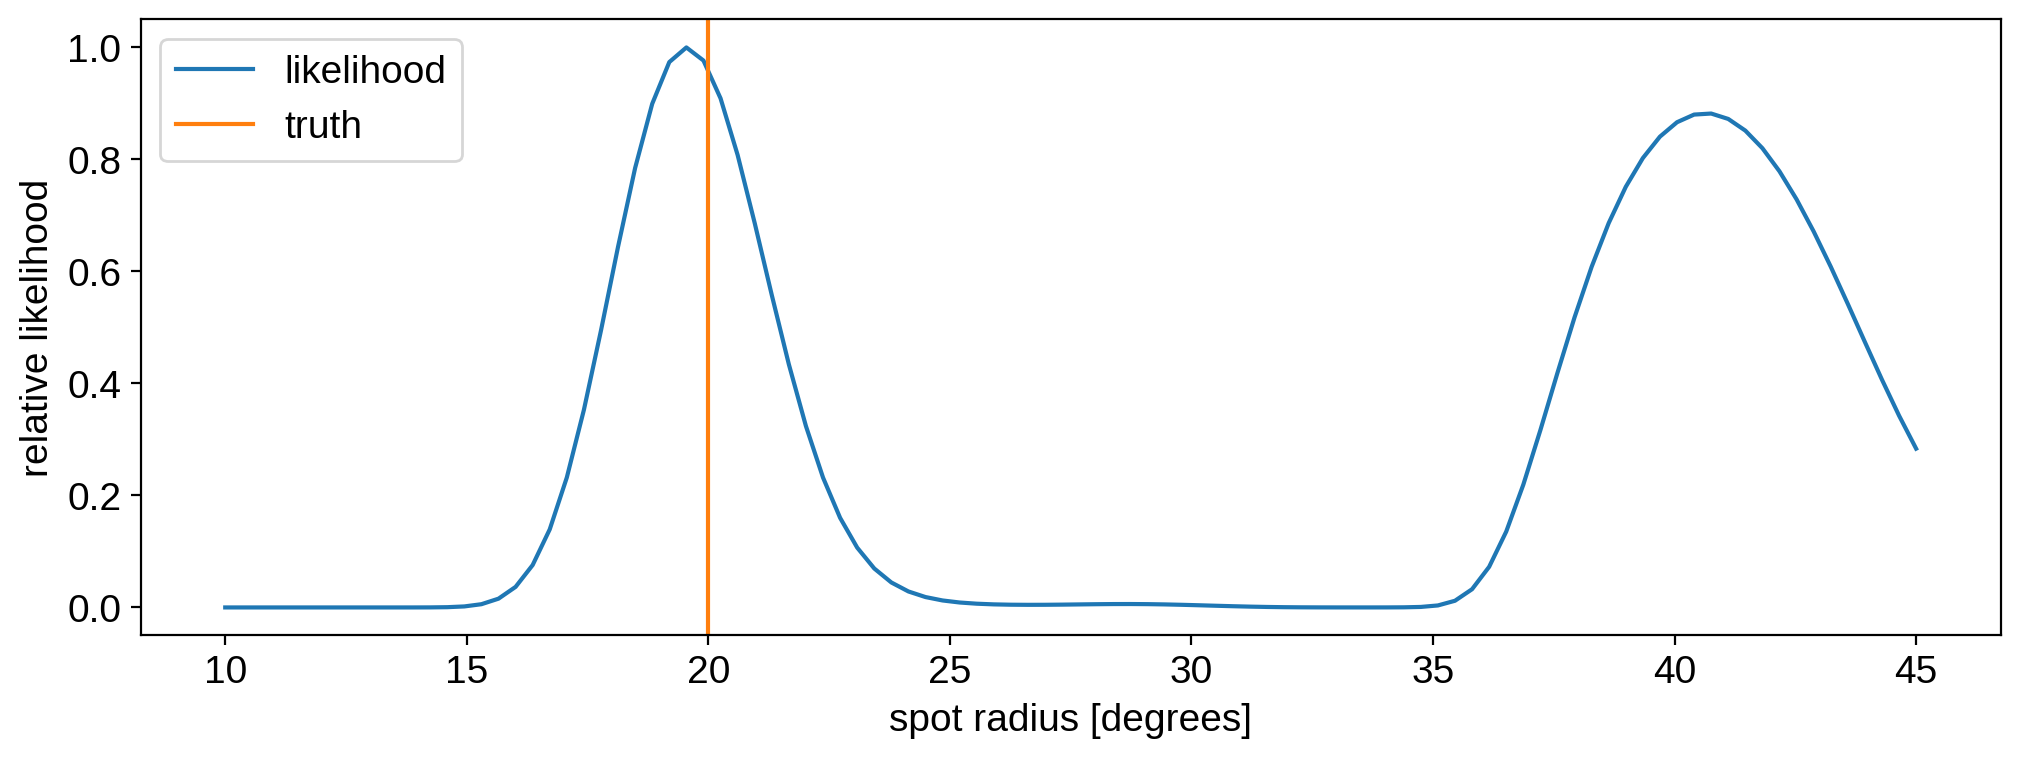

In [30]:
likelihood = np.exp(ll - np.max(ll))
plt.plot(r, likelihood, label="likelihood")
plt.axvline(20, color="C1", label="truth")
plt.legend()
plt.ylabel("relative likelihood")
plt.xlabel("spot radius [degrees]")
plt.show()

That looks pretty good! The likelihood peaks very close to the true value, and the truth is well within one standard deviation. But interestingly, we've uncovered a degeneracy! This particular light curve can be explained just as well with much larger spots of radius $\sim 40^\circ$!

If we put on our Bayesian hats for a moment, we can explicitly assert we're placing a uniform prior on the radius (between $10^\circ$ and $45^\circ$) and normalize the curve above so it integrates to unity to obtain an actual posterior probability distribution for the radius:

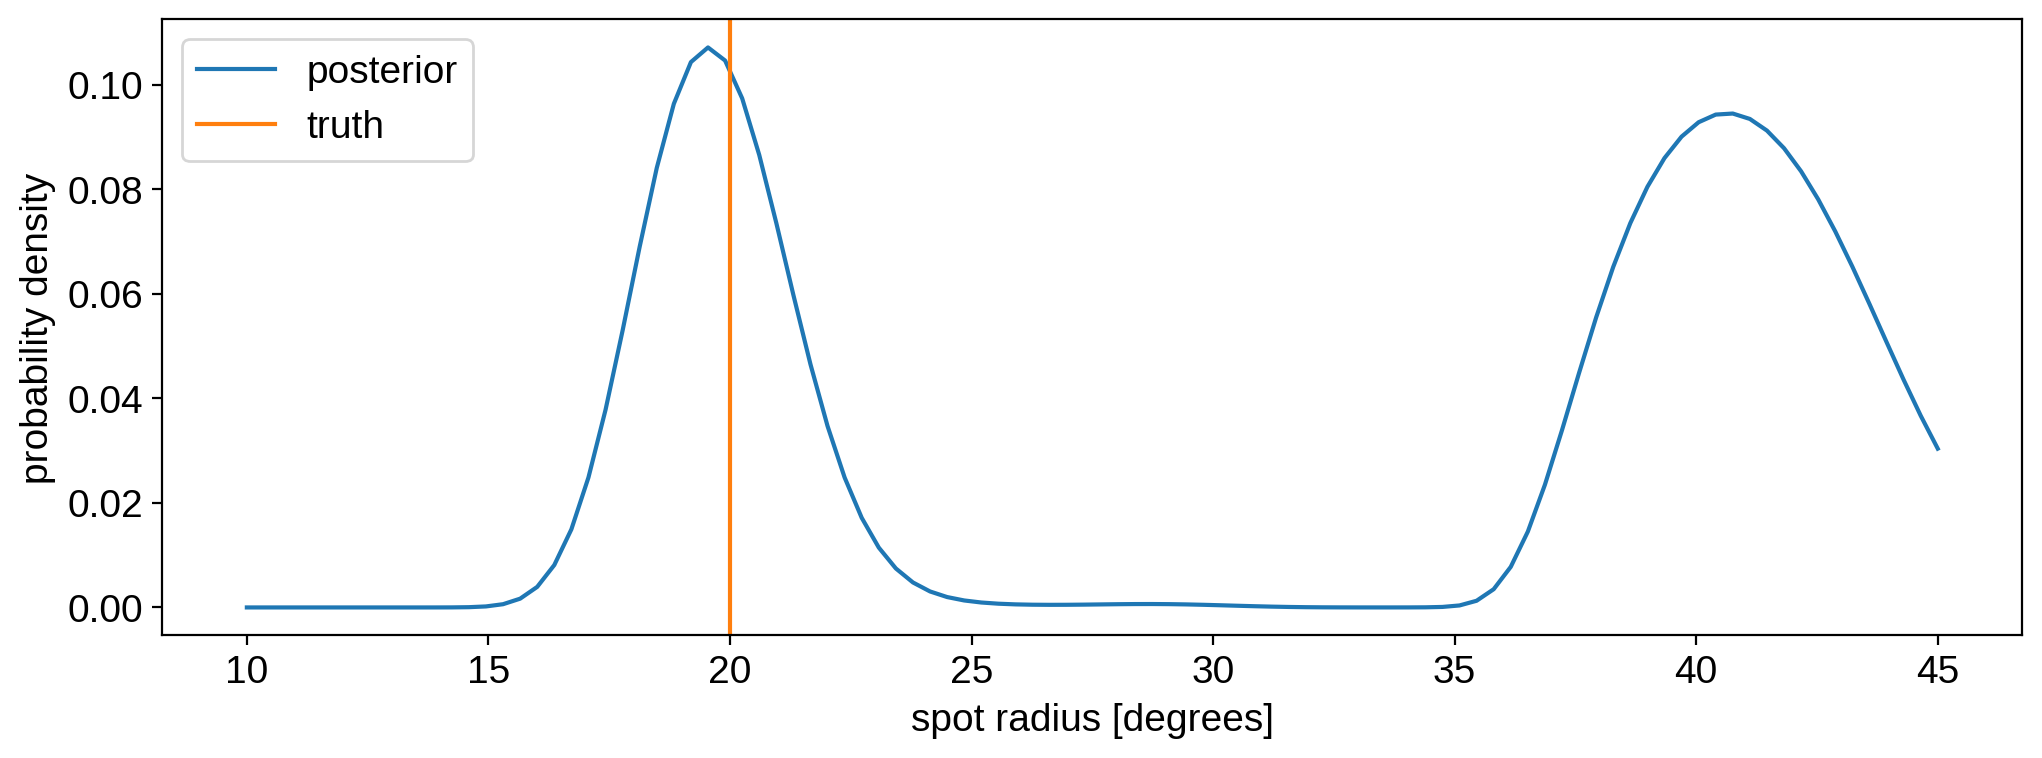

In [31]:
prob = likelihood / np.trapz(likelihood, r)
plt.plot(r, prob, label="posterior")
plt.axvline(20, color="C1", label="truth")
plt.legend()
plt.ylabel("probability density")
plt.xlabel("spot radius [degrees]")
plt.show()

## Ensemble analyses

As we argue in the paper, individual light curves simply aren't that constraining of the spot properties. In fact, the light curve in the example above is unable to confidently tell us if the spots are small or large! We can learn parameters much more precisely if we analyze many light curves of similar stars at once. To this end, let's analyze all 50 flux samples we generated earlier.

The joint probability is just the product of the probabilities for each dataset, so in log space we can simply take the sum over all 50 light curves:

In [32]:
r = np.linspace(10, 45, 100)
ll = np.zeros_like(r)
for k in tqdm(range(len(r))):
    ll[k] = np.sum([log_likelihood(f[n], r[k]) for n in range(50)])

  0%|          | 0/100 [00:00<?, ?it/s]

Here is our posterior constraint (as before) on the radius:

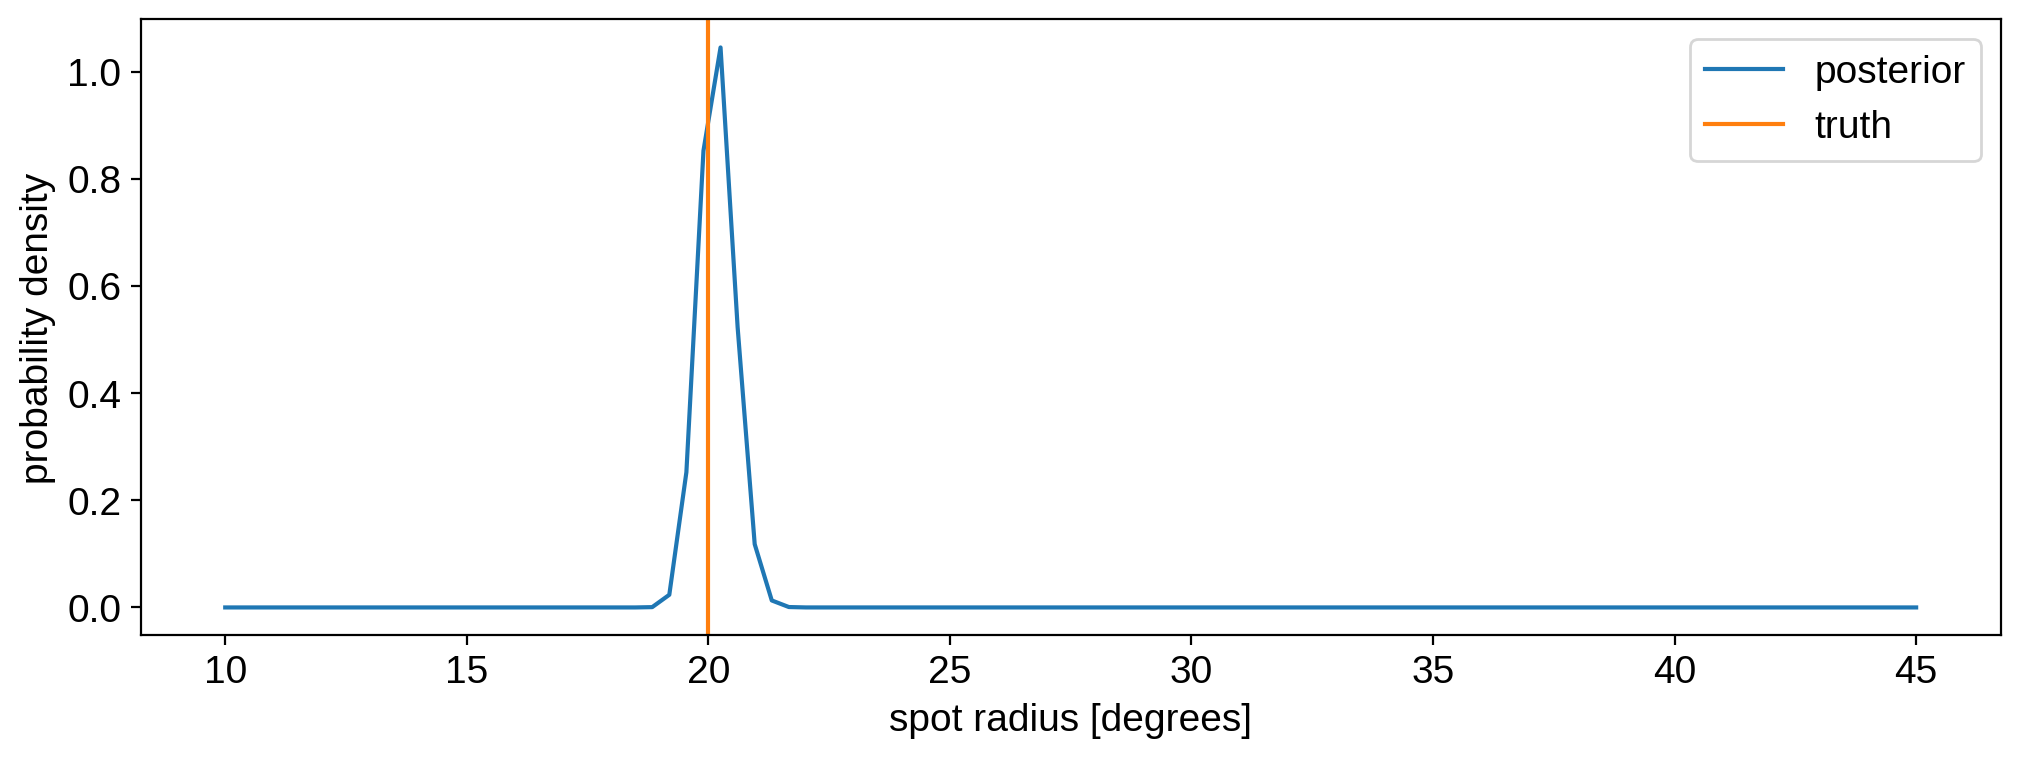

In [33]:
likelihood = np.exp(ll - np.max(ll))
prob = likelihood / np.trapz(likelihood, r)
plt.plot(r, prob, label="posterior")
plt.axvline(20, color="C1", label="truth")
plt.legend()
plt.ylabel("probability density")
plt.xlabel("spot radius [degrees]")
plt.show()

It's much, much tighter, still consistent with the truth, and the degeneracy is gone. Ensemble analyses rock!

That's it for this quick start tutorial. Be sure to check the other examples in this directory!